In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
from eofs.xarray import Eof

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('..')
from plotting.maps import CartopyMap
from plotting.mapareas import conus
from reanalysis.ncep_r1 import daily4x

In [2]:
def generate_dates(years, months, days):
    for year in years:
        for month in months:
            for day in days:
                yield pd.Timestamp(year, month, day)

In [3]:
years = range(1981, 2019)
months = [5]
days = range(16, 32)

dates = [ts + pd.Timedelta('1 day') for ts in generate_dates(years, months, days)]

In [7]:
ds = daily4x.mslp(dates)
ds_mean = ds.mean()
ds_anom = ds - ds_mean

In [14]:
ds_anom_shifted = ds_anom.geospatial.shiftgrid()
ds_anom_conus = ds_anom_shifted.geospatial.domain(*tuple(conus))
ds_anom_conus

<xarray.Dataset>
Dimensions:  (lat: 12, lon: 25, time: 608)
Coordinates:
  * lon      (lon) float32 -127.5 -125.0 -122.5 -120.0 ... -72.5 -70.0 -67.5
  * lat      (lat) float32 50.0 47.5 45.0 42.5 40.0 ... 32.5 30.0 27.5 25.0 22.5
  * time     (time) datetime64[ns] 1981-05-17 1981-05-18 ... 2018-06-01
Data variables:
    slp      (time, lat, lon) float32 138.48438 298.48438 ... 468.48438

In [15]:
coslat = np.cos(np.deg2rad(ds_anom_conus.coords['lat'].values)).clip(0., 1.)
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(ds_anom_conus.slp, weights=wgts)
eofs = solver.eofsAsCorrelation()
pcs = solver.pcs()

In [16]:
def plot_eofs(eofs, nrows, ncols, proj, bbox, clevs=None):
    if clevs is None:
        clevs = np.linspace(-1, 1, 20)
    
    for i in range(nrows * ncols):
        ax = plt.subplot(nrows, ncols, i + 1, projection=proj)
        bgmap = CartopyMap.from_axes(ax, bbox=bbox)
        bgmap.draw()
        eofs[i].plot.contourf(ax=bgmap.ax, cmap=plt.cm.RdBu_r, levels=clevs,
                                 transform=ccrs.PlateCarree(), add_colorbar=False)
        ax.set_aspect('equal')
        
    plt.subplots_adjust(wspace=0, hspace=0)

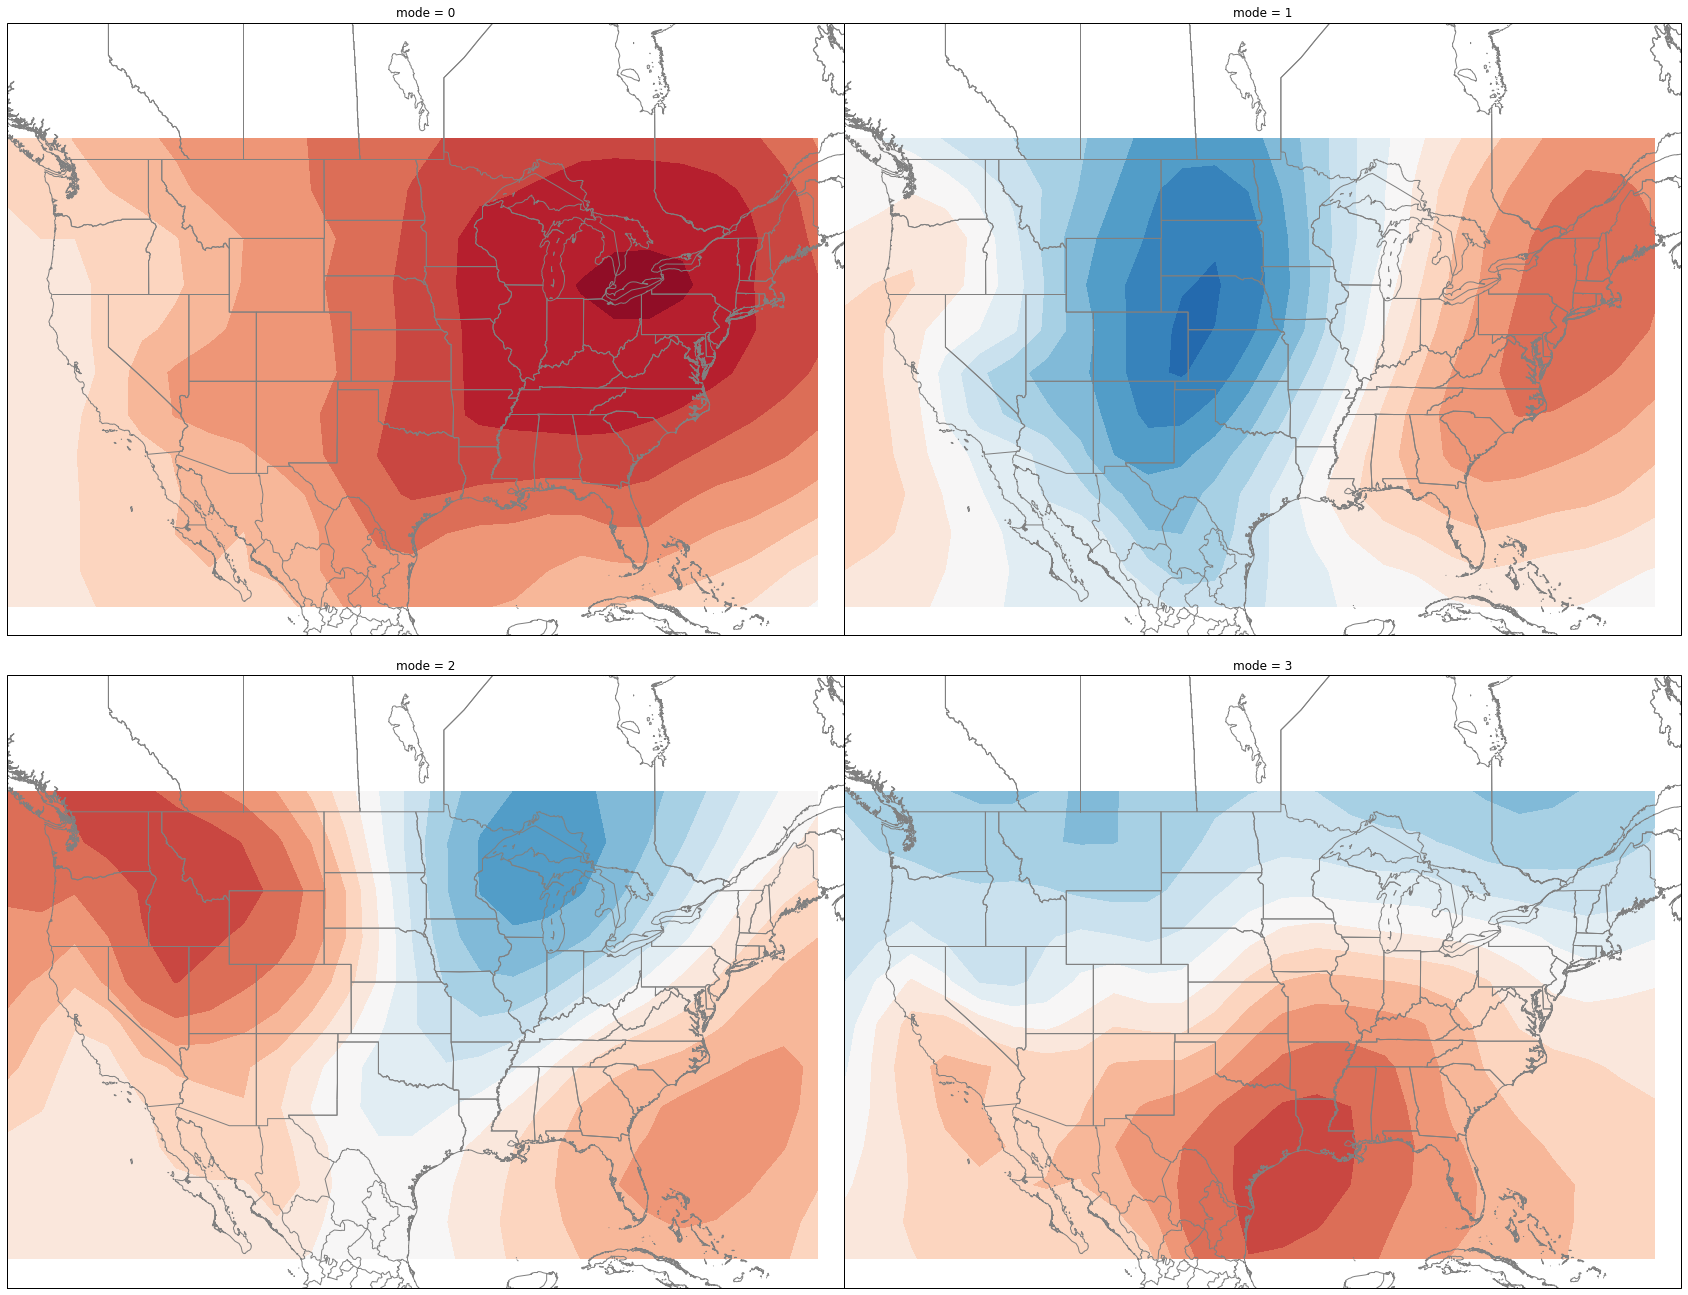

In [17]:
plt.figure(figsize=(30, 24))
plot_eofs(eofs, 2, 2, proj=ccrs.Mercator(), bbox=conus)

In [18]:
firstfewpcs = pcs.sel(mode=slice(0, 9)).to_dataframe().reset_index()
firstfewpcs.rename(columns={'time': 'date'}, inplace=True)

In [19]:
# firstfewpcs.to_csv('./slp_pcs_latemay_1981-2018.csv', index=False)